<a href="https://colab.research.google.com/github/cubecloud/fool_game/blob/feature-06-state-v005/fool_game_and_DDQN_env_steps_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### New Import

In [1]:
!pip install git+https://github.com/cubecloud/fool_game.git@feature-06-state-v005

  Cloning https://github.com/cubecloud/fool_game.git (to revision feature-06-state-v005) to /tmp/pip-req-build-pzm0eqzw
  Running command git clone -q https://github.com/cubecloud/fool_game.git /tmp/pip-req-build-pzm0eqzw
  Running command git checkout -b feature-06-state-v005 --track origin/feature-06-state-v005
  Switched to a new branch 'feature-06-state-v005'
  Branch 'feature-06-state-v005' set up to track remote branch 'feature-06-state-v005' from 'origin'.
  Created wheel for fool-game: filename=fool_game-0.2.22-cp37-none-any.whl size=28249 sha256=68e5b173cc005912033da79902e927536e4b420a60da8e96bb63896eacfcb8d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-74vhbvyh/wheels/ad/ee/33/8c3d7b9443c6d12e21799d3cec80666ce15128d1bc89271140
Successfully built fool-game


In [2]:
# adding terra_ai location for using googlesync 
# for development on local drive and testing 
# in google colab or jupyter notebook 
# change this variables to your locations for development
local_drive = '/home/cubecloud/GDrive'
remote_drive = '/content/drive/MyDrive'
local_dev = '/Python/fool_game/'
remote_dev = '/Python/fool_game/'
__demo_version__ = "0.1.0"
import sys
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
#     from google.colab import drive
#     drive.mount('/content/drive')
    DEV = f'{remote_drive}{remote_dev}'
    DRIVE = remote_drive
elif 'ipykernel' in str(get_ipython()):
    print('Running on Jupyter Notebook')
    DEV = f'{local_drive}{local_dev}'
    DRIVE = local_drive
else:
    sys.exit('Not running on CoLab or Jupyter notebook')
print(f'Adding sys path: {DEV}')
sys.path.append(DEV)
HOME = f'{DEV}data/'

#check environment 

import tensorflow
print('Checking key environment depenndecies')
!python --version
print('TensorFlow', tensorflow.__version__)
print('Keras', tensorflow.keras.__version__)


Running on CoLab
Adding sys path: /content/drive/MyDrive/Python/fool_game/
Checking key environment depenndecies
Python 3.7.10
TensorFlow 2.4.1
Keras 2.4.0


In [3]:
import collections
import numpy as np # импортируем библиотеку для работы с массивами данных
import tensorflow as tf
# from tensorflow.keras.models import Model, load_model 
# from tensorflow.keras import layers
# from tensorflow.keras.layers import Dense, Flatten, Input, Lambda, Conv2D, MaxPooling2D, Reshape, Multiply # из кераса загружаем необходимые слои для нейросети
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.optimizers import RMSprop, Adam, SGD, RMSprop# из кераса загружаем выбранный оптимизатор
import time                                # модуль для операций со временными характеристиками
import matplotlib.pyplot as plt            # импортируем библиотеку для визуализации данных
import seaborn as sns
import matplotlib
import pandas as pd
import pickle as pkl
import random
import sys
import os
from datetime import datetime, timedelta
from IPython.display import clear_output 

import pytz
timezone = pytz.timezone("Europe/Moscow")
# # "магическая" команда python для запуска библиотеки в ноутбуке
# %matplotlib inline

HOME = f'/content/drive/MyDrive/Python/fool_game/data/'
from google.colab import drive
drive.mount('/content/drive')

from importlib import reload
from cardgames import foolgame
foolgame = reload(foolgame)
print(tf.__version__)
print(tf.keras.__version__)
print(foolgame.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2.4.1
2.4.0
0.02.22


### Figshow

In [4]:
def figshow(df):
    fig = plt.figure(figsize=(26, 7))
    sns.set_style("white")
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_axisbelow(True)
    ax1.minorticks_on()
    ax1.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
    ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    last_game = int(df["game_episode"].max())
    # N = np.arange(0, last_game+1)
    n_games = 1
    if last_game // 400 > 0:
        n_games = last_game // 400
    

    plt.plot(df.loc[(df["game_episode"] % n_games == 0), "game_episode"], 
             df.loc[(df["game_episode"] % n_games == 0), "loss"], 
             linestyle='--', color='blue', label="loss")
    plt.plot(df.loc[(df["game_episode"] % n_games == 0), "game_episode"], 
             df.loc[(df["game_episode"] % n_games == 0), "epsilon"], 
             linestyle='--', color='green', label="epsilon")
    plt.title(f"Loss & epsilon")
    plt.legend()

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_axisbelow(True)
    ax2.minorticks_on()
    ax2.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
    ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    plt.plot(df.loc[(df["game_episode"] % n_games == 0), "game_episode"],
             df.loc[(df["game_episode"] % n_games == 0), 'mean_reward'], 
             linestyle='-', color='red', label="mean_reward")
    plt.title(f"mean_reward")
    plt.legend()
    plt.show()
    pass

In [5]:
!nvidia-smi

Tue May 18 08:47:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## The DQN model


In [6]:
import torch
import torch.nn as nn        # Pytorch neural network package
import torch.optim as optim  # Pytorch optimization package
import torch.nn.functional as F

# device = torch.device("cuda")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class ConvDQN(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(ConvDQN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.fc_input_dim = self.feature_size()
        
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, self.output_dim)
        )

    def forward(self, state):
        features = self.conv_net(state)
        features = features.view(features.size(0), -1)
        qvals = self.fc(features)
        return qvals

    def feature_size(self):
        return self.conv_net(autograd.Variable(torch.zeros(1, *self.input_dim))).view(1, -1).size(1)


class DQN(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.fc = nn.Sequential(
            nn.Linear(self.input_dim[0], 400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.ReLU(),
            nn.Linear(300, self.output_dim)
        )

    def forward(self, state):
        qvals = self.fc(state)
        return qvals

In [8]:
# Taken from 
# https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On/blob/master/Chapter06/lib/dqn_model.py

# class DQN(nn.Module):
#     def __init__(self, input_shape, n_actions):
#         super(DQN, self).__init__()

#         self.conv = nn.Sequential(
#             nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=4, stride=2),
#             nn.ReLU(),
#             nn.Conv2d(64, 64, kernel_size=3, stride=1),
#             nn.ReLU()
#         )

#         conv_out_size = self._get_conv_out(input_shape)
#         self.fc = nn.Sequential(
#             nn.Linear(conv_out_size, 512),
#             nn.ReLU(),
#             nn.Linear(512, n_actions)
#         )

#     def _get_conv_out(self, shape):
#         o = self.conv(torch.zeros(1, *shape))
#         return int(np.prod(o.size()))

#     def forward(self, x):
#         conv_out = self.conv(x).view(x.size()[0], -1)
#         return self.fc(conv_out)


# class DQN(nn.Module):
  
#   def __init__(self, input_dim, output_dim):
#       super(DQN, self).__init__()
#       self.input_dim = input_dim
#       self.output_dim = output_dim
      
#       self.fc = nn.Sequential(
#           nn.Linear(self.input_dim, 128),
#           nn.ReLU(),
#           nn.Linear(128, 256),
#           nn.ReLU(),
#           nn.Linear(256, self.output_dim),
#           # nn.Tanh()
#           )
#   def forward(self, state):
#       qvals = self.fc(state)
#       return qvals

In [9]:
# players_num = 2
# test_net = DQN((4536,), 37).to(device)
# print(test_net)

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'valid_action_lst','reward', 'done', 'next_state'])
class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = collections.deque(maxlen=capacity)
        pass

    def __len__(self):
        return len(self.buffer)

    def get_length(self):
        return self.__len__()

    def append(self, experience):
        self.buffer.append(experience)
        pass

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, valid_actions_lst, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return (np.array(states, dtype=np.float32), 
                np.array(actions, dtype=np.int64), 
                np.array(valid_actions_lst), 
                np.array(rewards, dtype=np.float32),
                np.array(dones, dtype=np.uint8), 
                np.array(next_states, dtype=np.float32))

    def save(self, file_path, buffer_length=10000):
        len_buffer = len(self.buffer)
        with open(file_path, "wb") as f:
            print('Save exp buffer...')
            if not (self.capacity is None) \
                    and (len_buffer < self.capacity) \
                    and (len_buffer < buffer_length):
                buffer_length = len_buffer
            else:
                buffer_length = len_buffer
            states, actions, valid_actions_lst, rewards, dones, next_states = \
                zip(*[self.buffer[idx] for idx in range(len(self.buffer) - buffer_length, len(self.buffer))])
            pkl.dump([states, actions, valid_actions_lst, rewards, dones, next_states], f)
            del [states, actions, valid_actions_lst, rewards, dones, next_states]
            pass

    def load(self, file_path):
        with open(file_path, "rb") as f:
            print('Loading exp buffer...')
            # self.buffer = pkl.load(f)
            states, actions, valid_actions_lst, rewards, dones, next_states = pkl.load(f)
            for state, action, valid_action_lst, reward, done, next_state in zip(states, actions, valid_actions_lst, rewards, dones, next_states):
                exp = Experience(state, action, valid_action_lst, reward, done, next_state)
                self.buffer.append(exp)
            del [states, actions, valid_actions_lst, rewards, dones, next_states]
        pass

# Pytorch *Agent*

In [12]:
players_num = 2
num_actions=37

# sync_target_turns = 3000       
replay_start_size = 10000       # start replay at turn_idx

model = DQN((518,), 37).to(device)
target_model = DQN((518,), 37).to(device)

# print(next(model1.parameters()).device)
# print(next(model2.parameters()).device)
# net = DQN((4536), 37).to(device)
# target_net = DQN((4536), 37).to(device)

In [13]:
class Agent:
    def __init__(self, 
                 env, 
                 exp_buffer,
                 exp_buffer_size = 50000):
        self.env = env
        self.observer_player = env.observer_player
        self.exp_buffer = exp_buffer
        self.exp_buffer_size = exp_buffer_size
        self.verbose = False
        self.debug_verbose = 1
        self.gamma = 0.99
        self._reset()
        pass

    def _reset(self):
        self.state = np.reshape(self.env.reset(), 518)
        self.total_reward: float = 0.0
        self.env.verbose = self.verbose
        self.env.debug_verbose = self.debug_verbose
        self.env.step(0, first_step=True)
        self.turns_counter = 0
        pass

    def play_step(self, net, epsilon=0.0, step_device="cpu"):
        done_reward = None
        self.turns_counter += 1
        self.env.epsilon = epsilon
        step_valid_actions = self.env.pl[self.observer_player].analyze()
        if np.random.random() < epsilon:
            action = random.choice(step_valid_actions)
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a).to(step_device)
            q_vals_v = net.forward(state_v)
            # action = np.argmax(q_vals_v.cpu().detach().numpy())
            # print(next(net.parameters()).device)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

            # state_a = np.array([self.state], copy=False)
            # state = torch.FloatTensor(state_a).float().unsqueeze(0).to(device)
            # qvals = net.forward(state)
            # action = np.argmax(qvals.cpu().detach().numpy())

            # state_a = np.array([self.state], copy=False)
            # state_tensor = tf.convert_to_tensor(state_a)
            # q_values = nnmodel(state_tensor, training=False)
            # # with np.printoptions(precision=3, suppress=True):
            # #     print(q_values.numpy())
            # valid_masks = tf.one_hot(valid_action_list, self.env.num_actions)
            # # with np.printoptions(precision=3, suppress=True):
            # #     print(masks.numpy())
            # valid_q_values = tf.expand_dims(tf.reduce_sum(tf.multiply(q_values, valid_masks), axis=0), 0)
            # # with np.printoptions(precision=3, suppress=True):
            # #     print(valid_q_values.numpy())
            # action = np.argmax(valid_q_values)
            # # print(self.action, action_list, action)
        if not (action in step_valid_actions):
            # action = step_valid_actions[0]
            # action = random.choice(step_valid_actions)
            ''' keeping the same state for new_state but adding negative reward'''
            new_state = np.squeeze(state_a, axis=0)
            self.state = np.squeeze(state_a, axis=0)
            # print(new_state.shape)
            # print(self.state.shape)
            ''' negative reward for not valid action '''
            reward = -0.007
            is_done = False
            self.total_reward += reward
            exp = Experience(self.state, action, step_valid_actions, reward, is_done, new_state)
            self.exp_buffer.append(exp)
            action = random.choice(step_valid_actions)
        ''' 
        step_epsilon - setting to 1.0 - totally random action from agent 
        trying to learn - how to play valid actions (index + zero (pass)) 
        '''
        new_state, reward, is_done, info = self.env.step(action, step_epsilon=1.0)
        new_state = np.reshape(new_state, 518)
        # if self.verbose:
            # print("Last action", action)
            # print(info)
        self.total_reward += reward
        exp = Experience(self.state, action, step_valid_actions, reward, is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done or self.turns_counter > 100:
            done_reward  = self.total_reward
            self.verbose = False
            self.debug_verbose = 1
            self._reset()
        return done_reward

In [14]:
MEAN_REWARD_BOUND = 0.85         

buffer = ExperienceReplay(replay_start_size)
environment = foolgame.Environment(players_num,
                                   env_type="dummy",
                                   observer_player=1,
                                   nnmodel=None)
game_table = Agent(environment,
                   exp_buffer=buffer)

gamma = 0.99
tau = 0.00005                                   
batch_size = 128                   

eps_start = 1.0
eps_decay = .999985             #changed start from .999985
eps_min = 0.07                  

Loaded /content/drive/MyDrive/Python/fool_game/data/fool_cardgame_weights_12500.h5 save, for model & model_target. Starting training from 12500


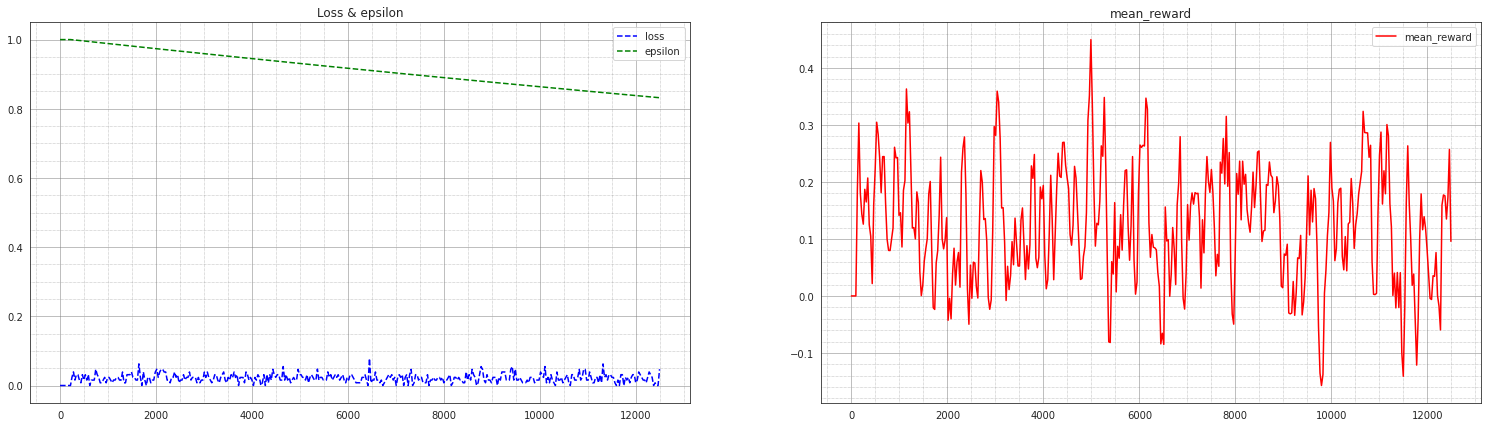

       game_episode     turns      time      loss   epsilon  mean_reward
12486       12486.0  565985.0  0.142196  0.007837  0.831980     0.157471
12487       12487.0  566022.0  0.124271  0.039106  0.831968     0.157349
12488       12488.0  566066.0  0.149935  0.015567  0.831955     0.137451
12489       12489.0  566113.0  0.157083  0.007835  0.831943     0.137085
12490       12490.0  566162.0  0.164226  0.015682  0.831930     0.116333
12491       12491.0  566206.0  0.142772  0.015621  0.831918     0.115662
12492       12492.0  566243.0  0.116603  0.007858  0.831906     0.115845
12493       12493.0  566291.0  0.161492  0.047129  0.831893     0.095825
12494       12494.0  566344.0  0.165596  0.023415  0.831881     0.095764
12495       12495.0  566387.0  0.131911  0.015679  0.831868     0.096313
12496       12496.0  566419.0  0.099428  0.031300  0.831856     0.096924
12497       12497.0  566463.0  0.136075  0.023575  0.831843     0.097168
12498       12498.0  566507.0  0.138256  0.007830  

In [15]:
model_weights_save_name = 'fool_cardgame_weights'
history_csv_name = 'fool_cardgame_hst.csv'
exp_pkl_name = 'fool_cardgame_exp.pkl'
cols = ['game_episode',
        'turns',  
        'time', 
        'loss',
        'epsilon',
        'mean_reward', 
       ]

def get_pd_data(pdfile):
  df_data = pd.read_csv(os.path.join(HOME, pdfile), index_col=0)
  return df_data

def add_data_to_pd(df_data, _game_episode, _turns, _time, _loss, _epsilon, _mean_reward):
  df_data = df_data.append({'game_episode': _game_episode,
                            'turns': _turns,
                            'time': _time,
                            'loss': _loss,
                            'epsilon': _epsilon,
                            'mean_reward': _mean_reward,
                            }, ignore_index=True)
  # print(self.df.to_string())
  return df_data
  
def load_checkpoint(save_name):
    pd_file_path =  os.path.join(HOME, history_csv_name)
    if os.path.exists(pd_file_path):    
      df = get_pd_data(pd_file_path)
      pd_start_game= int(df.game_episode.max())
    else:
      pd_start_game = 0
      df = pd.DataFrame(columns=cols)
    start_game = 0
    mean_reward = 0
    rewards_in_row = []
    dirlist = os.listdir(HOME)
    for i in range (len(dirlist)):
      filename = dirlist[i]
      if save_name in filename:
        if '_' in filename: 
          try: 
            epoch = int((filename.split('_')[-1]).split('.')[-2])
          except ValueError:
            epoch = 0
          if epoch > start_game:
            start_game = epoch
    if pd_start_game > start_game:
      df.drop(index = [i for i in range(start_game+1, pd_start_game+1)], axis=0, inplace=True)
    if start_game > 0:
      file_path = os.path.join(HOME, f'{save_name}_{start_game}.h5')
      model.load_state_dict(torch.load(file_path))
      target_model.load_state_dict(torch.load(file_path))

      print(f"Loaded {file_path} save, for model & model_target. Starting training from {start_game}")
      # last epoch +1
      epsilon = float(df.loc[(df["game_episode"]==start_game), "epsilon"].item())
      mean_reward = float(df.loc[(df["game_episode"]==start_game), "mean_reward"].item())
    else:
      epsilon = 1.0
      print(f"Starting from scratches. Starting game = {start_game}")
      rewards_in_row = []
    return df, start_game, epsilon, mean_reward, rewards_in_row

df, start_game, epsilon, mean_reward, rewards_in_row = load_checkpoint(model_weights_save_name)

if start_game != 0:
  turn_idx = int(df.turns.max())
  figshow(df)
  game_episode = start_game
  total_rewards = []
  total_rewards = df.loc[(df["game_episode"]<=start_game) &(df["game_episode"]>=start_game-100), "mean_reward"].values.tolist()
  # epsilon = 0.1
  learning_rate = 0.00025
  adam_hat = 1e-8
  game_time = 0
  if game_episode > 200:
    lr_decay = 200/game_episode
    learning_rate = learning_rate * lr_decay
    if learning_rate < adam_hat:
      learning_rate = adam_hat
else:
  turn_idx = 0
  mean_reward = 0
  game_episode = -1
  epsilon = eps_start
  total_rewards = []
  learning_rate = 0.00025 

print(df.tail(15).to_string())
print(f'Start game episode:', start_game)
print('Turn index:', turn_idx)
print('Epsilon:', epsilon)
print('Learning rate:', learning_rate)
print('Mean reward on last game episode:', mean_reward)
print(f'_mean_ of Total rewards for last 100 games: {np.mean(total_rewards[-100:]) if total_rewards else None}')

exp_file_path = os.path.join(HOME, f'{exp_pkl_name}')
if start_game != 0:
  if os.path.exists(exp_file_path):
    buffer.load(exp_file_path)
  else:
    msg = f"Warning: pickle Exp file not found, starting without" 
    print(msg)

time_sum = int(df["time"].sum())
print(f'Model learning {start_game} games and {timedelta(seconds=time_sum)}')

>>>Training starts at  2021-05-18 11:47:38.980323+03:00
game_episode: 0012501, turn: 000566620, epsilon: 0.832, mean reward: 0.178, loss: 0.0080, last reward 1.0791015625. Best mean reward updated 0.178, episodes time: 0.1319 sec
game_episode: 0012600, turn: 000571134, epsilon: 0.831, mean reward: -0.063, loss: 0.0079, last reward 1.0869140625, episodes time: 14.3696 sec
game_episode: 0012700, turn: 000575650, epsilon: 0.829, mean reward: 0.062, loss: 0.0235, last reward -0.9111328125, episodes time: 14.0519 sec
game_episode: 0012800, turn: 000580143, epsilon: 0.828, mean reward: 0.113, loss: 0.0234, last reward 1.060546875, episodes time: 13.9930 sec
game_episode: 0012866, turn: 000583129, epsilon: 0.827, mean reward: 0.193, loss: 0.0235, last reward 1.0556640625. Best mean reward updated 0.193, episodes time: 9.4354 sec
game_episode: 0012867, turn: 000583181, epsilon: 0.827, mean reward: 0.213, loss: 0.0235, last reward 1.1025390625. Best mean reward updated 0.213, episodes time: 0.1

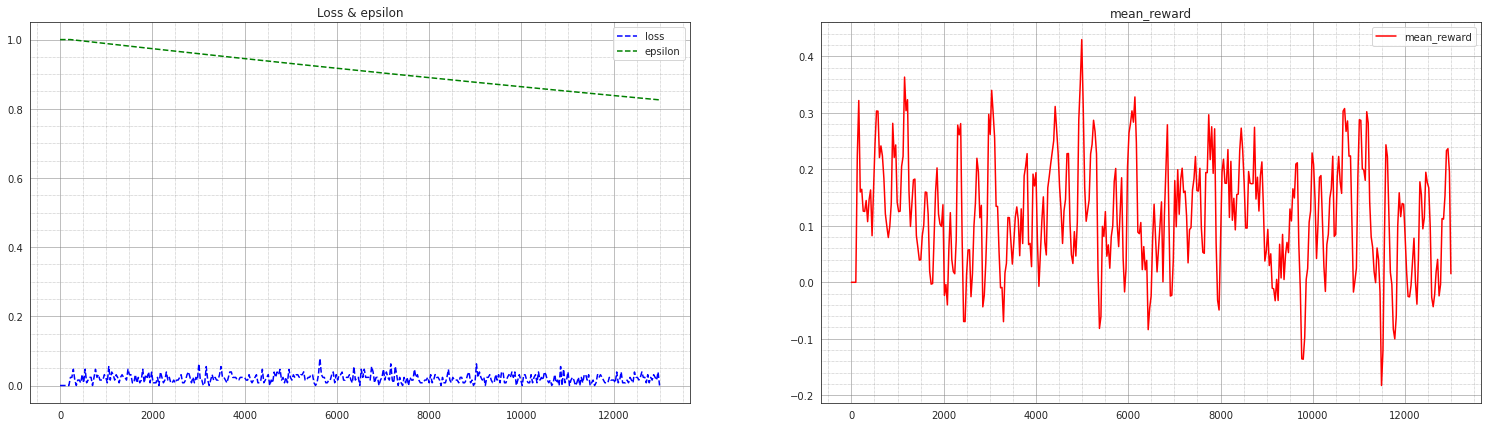

game_episode: 0013100, turn: 000593827, epsilon: 0.824, mean reward: 0.134, loss: 0.0392, last reward 1.103515625, episodes time: 15.7292 sec
game_episode: 0013200, turn: 000598502, epsilon: 0.823, mean reward: 0.055, loss: 0.0235, last reward -0.89404296875, episodes time: 14.8111 sec
game_episode: 0013300, turn: 000602846, epsilon: 0.822, mean reward: 0.092, loss: 0.0001, last reward 1.09375, episodes time: 13.7389 sec
game_episode: 0013400, turn: 000607334, epsilon: 0.821, mean reward: 0.095, loss: 0.0157, last reward 1.087890625, episodes time: 14.2535 sec
game_episode: 0013500, turn: 000611893, epsilon: 0.819, mean reward: 0.172, loss: 0.0625, last reward 1.0048828125, episodes time: 14.4476 sec
game_episode: 0013522, turn: 000612859, epsilon: 0.819, mean reward: 0.294, loss: 0.0235, last reward 1.08203125. Best mean reward updated 0.294, episodes time: 3.2189 sec
game_episode: 0013533, turn: 000613410, epsilon: 0.819, mean reward: 0.294, loss: 0.0157, last reward 1.04296875. Best

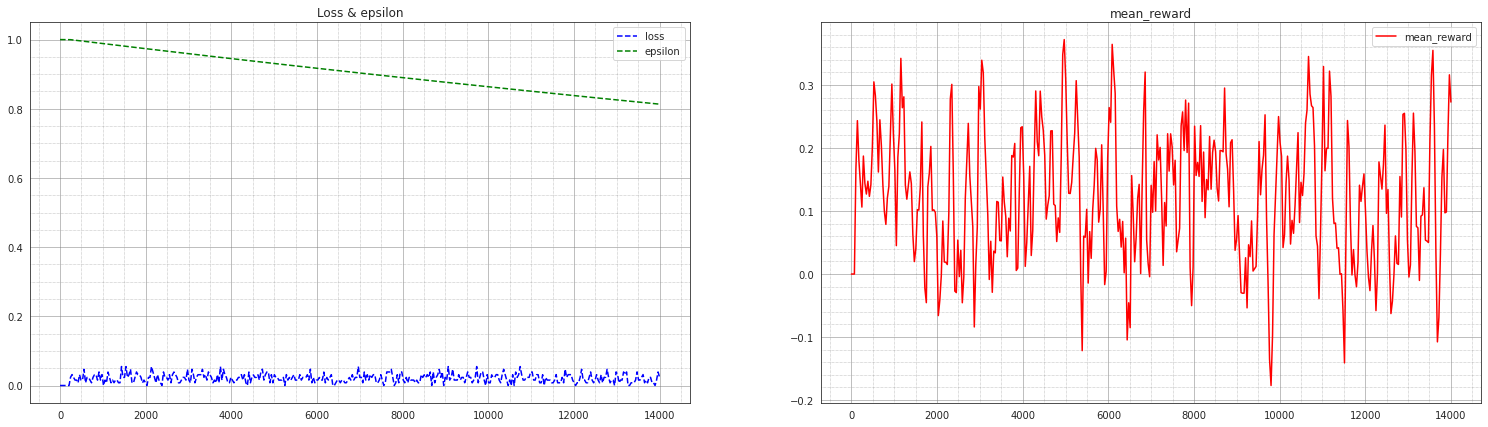

game_episode: 0014100, turn: 000638980, epsilon: 0.812, mean reward: 0.009, loss: 0.0000, last reward 1.0595703125, episodes time: 15.0878 sec
game_episode: 0014200, turn: 000643332, epsilon: 0.811, mean reward: 0.050, loss: 0.0311, last reward 1.0927734375, episodes time: 13.9776 sec
game_episode: 0014300, turn: 000647667, epsilon: 0.810, mean reward: 0.311, loss: 0.0079, last reward 1.0966796875, episodes time: 13.8172 sec
game_episode: 0014400, turn: 000652115, epsilon: 0.808, mean reward: 0.065, loss: 0.0312, last reward -0.9501953125, episodes time: 14.2174 sec
game_episode: 0014500, turn: 000656607, epsilon: 0.807, mean reward: -0.093, loss: 0.0236, last reward 1.080078125, episodes time: 14.2997 sec
game_episode: 0014600, turn: 000661214, epsilon: 0.806, mean reward: 0.052, loss: 0.0157, last reward -0.916015625, episodes time: 14.9108 sec
game_episode: 0014700, turn: 000665680, epsilon: 0.805, mean reward: 0.149, loss: 0.0469, last reward 1.068359375, episodes time: 14.2296 sec

In [ ]:
# optimizer = optim.Adam(net.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters())

msg_display = True
best_mean_reward = None
num_actions = 37
loss_numpy = 0
loss = 0
start_datetime = datetime.now(timezone)
print(">>>Training starts at ", start_datetime)
start_time = time.time()
episodes_start_time = time.time()

while True:
        turn_idx += 1
        if len(buffer) < replay_start_size:
            epsilon = 1.0
        reward = game_table.play_step(model, epsilon=epsilon, step_device=device)
        if reward is not None:
            epsilon = max(epsilon*eps_decay, eps_min)
            reward = np.float16(reward)
            game_episode += 1
            total_rewards.append(reward)
            if len(total_rewards) > 100:
              mean_reward = np.mean(total_rewards[-100:])
              del total_rewards[:1]
            msg = f"\rgame_episode: {game_episode:07d}, turn: {turn_idx:09d}, epsilon: {epsilon:.3f}, " \
                  f"mean reward: {mean_reward:.3f}, loss: {loss_numpy:.4f}, " \
                  f"last reward {reward}"

            if (best_mean_reward is None or best_mean_reward < mean_reward) \
              and game_episode > 1000:
                best_mean_reward = mean_reward
                if best_mean_reward is not None:
                    torch.save(model.state_dict(), os.path.join(HOME, f'{model_weights_save_name}_{game_episode:002d}.h5'))
                    msg = f"\rgame_episode: {game_episode:07d}, turn: {turn_idx:09d}, epsilon: {epsilon:.3f}, " \
                    f"mean reward: {mean_reward:.3f}, loss: {loss_numpy:.4f}, " \
                    f"last reward {reward}"
                    msg = f'{msg}. Best mean reward updated {best_mean_reward:.3f}'
                    msg_display = True

            if mean_reward > MEAN_REWARD_BOUND \
              and len(buffer) > replay_start_size \
              and epsilon == 0.02:
                end_time = time.time()
                game_time = end_time - start_time 
                start_time  = time.time()
                print(f'{msg}, time: {game_time:.4f} sec')    
                print("Solved in %d turns!" % turn_idx)
                loss_numpy = loss_t.item()
                # if tf.is_tensor(loss):
                    # loss_numpy = tf.keras.backend.get_value(loss)
                df = add_data_to_pd(df, game_episode, turn_idx, game_time, loss_numpy, epsilon, mean_reward)
                df.to_csv(os.path.join(HOME, history_csv_name), encoding='utf-8')
                break
            end_time = time.time()
            game_time = end_time - start_time 
            start_time  = time.time()

            # if tf.is_tensor(loss):
                # loss_numpy = tf.keras.backend.get_value(loss)    
            if game_episode % 100 == 0 or msg_display:
              episodes_end_time = time.time()
              episodes_time = episodes_end_time - episodes_start_time 
              episodes_start_time  = time.time() 
              print(f'{msg}, episodes time: {episodes_time:.4f} sec')
              msg_display = False
            df = add_data_to_pd(df, game_episode, turn_idx, game_time, loss_numpy, epsilon, mean_reward)
            if (game_episode % 500 == 0) and (game_episode != 0):
                df.to_csv(os.path.join(HOME, history_csv_name), encoding='utf-8')
            if (game_episode % 2500 == 0) and (game_episode != 0) and (turn_idx >= replay_start_size):
                print('Saving weights...')
                torch.save(model.state_dict(), os.path.join(HOME, f'{model_weights_save_name}_{game_episode:002d}.h5'))
                buffer.save(exp_file_path, buffer_length=50000)
            if game_episode % 1000 == 0:
                figshow(df)
            if (game_episode % 10000 == 0) and (game_episode != 0):  
                clear_output()
                print(df.tail(50).to_string())
                figshow(df)
        if len(buffer) < replay_start_size:
            continue

        batch = buffer.sample(batch_size)
        states, actions, valid_actions_lst, rewards, dones, next_states = batch

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.ByteTensor(dones).to(device)

        # resize tensors
        actions = actions.view(actions.size(0), 1)
        dones = dones.view(dones.size(0), 1)

        # compute loss
        curr_Q = model.forward(states).gather(1, actions)
        next_Q = target_model.forward(next_states)
        max_next_Q = torch.max(next_Q, 1)[0]
        max_next_Q = max_next_Q.view(max_next_Q.size(0), 1)
        # max_next_Q = max_next_Q.to(device)
        expected_Q = rewards + (1 - dones) * gamma * max_next_Q
        # expected_Q = expected_Q.to(device)

        loss = F.mse_loss(curr_Q, expected_Q.detach())
        # loss = nn.MSELoss()(curr_Q, expected_Q.detach)

        # states_v = torch.tensor(states).to(device)
        # next_states_v = torch.tensor(next_states).to(device)
        # actions_v = torch.tensor(actions).to(device)
        # rewards_v = torch.tensor(rewards).to(device)
        # done_mask = torch.ByteTensor(dones).to(device)

        # state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)

        # next_state_values = target_net(next_states_v).max(1)[0]

        # next_state_values[done_mask] = -1.0

        # next_state_values = next_state_values.detach()

        # expected_state_action_values = next_state_values * gamma + rewards_v

        # loss_t = nn.MSELoss()(state_action_values, expected_state_action_values)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_numpy = loss.item()
        
        # target network update
        if turn_idx % 2 == 0:
          for target_param, param in zip(target_model.parameters(), model.parameters()):
              target_param.data.copy_(tau * param + (1 - tau) * target_param)

        # if turn_idx % sync_target_turns == 0:
            # update the the target network with new weights
            # print("Synchronizing models...")
            # target_net.load_state_dict(net.state_dict())
            # model_target.set_weights(model.get_weights())
        # for target_param, param in zip(target_net.parameters(), net.parameters()):
        #     target_param.data.copy_(tau * param + (1 - tau) * target_param)

print('Saving weights...')
torch.save(model1.state_dict(), os.path.join(HOME, f'{model_weights_save_name}_{game_episode:002d}.h5'))
buffer.save(exp_file_path)
figshow(df)

end_datetime = datetime.now(timezone)
print(">>>Training ends at ", end_datetime)
train_time = end_datetime-start_datetime
print(f'Model trained:', train_time)
